<a href="https://colab.research.google.com/github/amimoon/AI_DeepLearning_Personal_Project/blob/main/%EA%B2%BD%EC%98%81%EC%9E%90%EB%A5%BC%EC%9C%84%ED%95%9CAI%EB%94%A5%EB%9F%AC%EB%8B%9D_%EA%B0%9C%EC%9D%B8%EA%B3%BC%EC%A0%9C_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kaggle Competition - Contradictory, My Dear Watson**


* Competition Title : Contradictory, My Dear Watson(Detecting contradiction and entailment in multilingual text using TPUs)
* Description : 다양한 언어(14개 언어)로 주어진 전제문장(Promise)와 가설문장(hypothesis) 간의 문맥을 파악하여 entailment(0), neutral(1), contradiction(2)로 분류하는 자연어 추론 문제
* Evaluation 지표 : accuracy

# **Kaggle Competiton Notebook**

* **Github Colne**

   guihub에 저장된 데이터 사용을 위해 Colab으로 Clone


In [28]:
%cd /content

/content


In [29]:
import os
if not os.path.exists('AI_DeepLearning_Personal_Project'):
  !git clone https://github.com/amimoon/AI_DeepLearning_Personal_Project.git

In [30]:
% cd /content/AI_DeepLearning_Personal_Project

/content/AI_DeepLearning_Personal_Project


* **Initial Settings**

In [31]:
!pip install transformers

In [32]:
import pandas as pd   
import numpy as np

import plotly.figure_factory as ff
import seaborn as sns 

from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

In [33]:
'''
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    
print('Number of replicas:', strategy.num_replicas_in_sync)
'''

"\nimport tensorflow as tf\n\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nexcept ValueError:\n    strategy = tf.distribute.get_strategy() # for CPU and single GPU\n    \nprint('Number of replicas:', strategy.num_replicas_in_sync)\n"

*  **Data Load**

In [34]:
train = pd.read_csv("./Data/train.csv", header=0, delimiter=",")
test = pd.read_csv("./Data/test.csv", header=0, delimiter=",")
submission = pd.read_csv("./Data/sample_submission.csv", header=0, delimiter=",")

In [35]:
print("Train Shape", train.shape, "Test Shape", test.shape, "Submission Shape", submission.shape);

Train Shape (12120, 6) Test Shape (5195, 5) Submission Shape (5195, 2)


In [36]:
train.head(5)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


* **EDA**

   Label, 언어 별 데이터 분포 확인

In [37]:
temp = train.groupby('label').count()['id'].reset_index().sort_values(by='id',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,id
0,0,4176
2,2,4064
1,1,3880


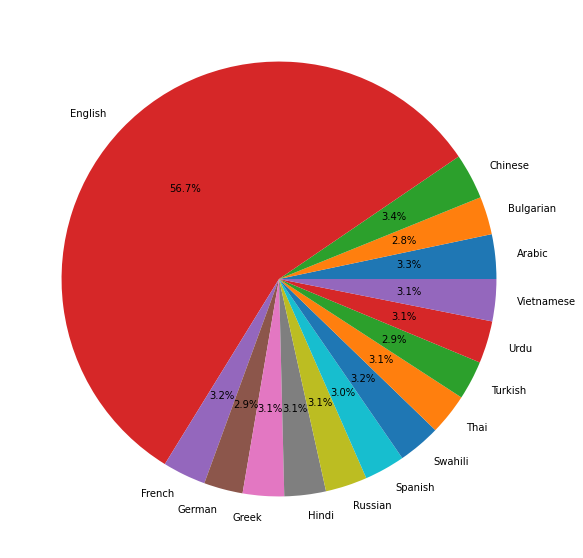

In [38]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

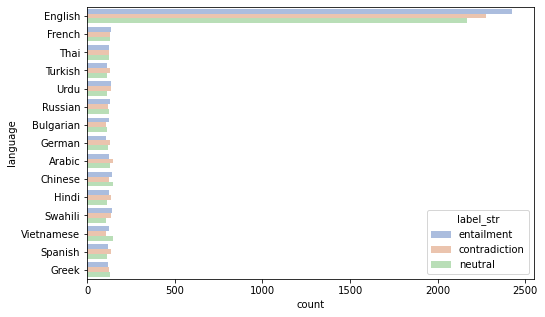

In [39]:
train['label_str'] = train['label'].map({0 : "entailment", 1 : "neutral", 2 : "contradiction"})

plt.figure(figsize=(8,5))
sns.countplot(y ='language', hue = "label_str", data = train, alpha=.5, palette="muted")

> Premise, hypothesis 문장 별 데이터 길이 분포 확인

In [40]:
train['premise_len'] = train['premise'].str.len()
train['hypothesis_len'] = train['hypothesis'].str.len()

In [41]:
#hist_data = pd.DataFrame()
hist_data = [train['premise_len'],train['hypothesis_len']]

group_labels = ['Premise', 'Hypothesis']

fig = ff.create_distplot(hist_data, group_labels, show_curve=False)
fig.update_layout(title_text='Distribution of Length Of Sentence')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

* **Preparing Data for Input**

   언어별 Tokenize를 위해 roberta의 Pretrained 모델(joeddav/xlm-roberta-large-xnli의 AutoTokenizer 활용

   AutoTokenizer를 통해 Train 데이터의 아래 구조로 문장 Token 사이에 Sperator가 추가되어 데이터가 Tokenize됨
   
   [CLS] + Primise 문장 tokenize + [SEP] +  Hypothesis 문장 tokenize + [SEP]

In [42]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

   Task의 Label과 joeddav/xlm-roberta-large-xnli 의 Label이 상이하므로 변환

   * Task Lebel : entailment(0), neutral(1), contradiction(2)

   * Model Label : contradiction(0), neutral(1), entailment(2)

In [43]:
train['label'] = train['label'].replace([0, 2], [2, 0])
train.head()

,id,premise,hypothesis,lang_abv,language,label,label_str,premise_len,hypothesis_len
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,2,entailment,68,81
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,0,contradiction,81,58
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,2,entailment,92,37
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,2,entailment,92,50
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1,neutral,182,47


In [44]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [45]:
max_len = 70

def bert_encode(hypotheses, premises, tokenizer, max_length=max_len):

    x = ['[CLS] ' + h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]
    x = tokenizer(x, padding=True, truncation=True, max_length=max_length)

    inputs = {
          'input_word_ids':tf.ragged.constant(x['input_ids']).to_tensor(),
          'input_mask': tf.ragged.constant(x['attention_mask']).to_tensor(),
          'input_type_ids': tf.ragged.constant(x['token_type_ids']).to_tensor()}

    return inputs

In [46]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

* **Creating & Training Mode**

   BERT Model(bert-base-multilingual-cased)로 모델 구성
   
   activation Function을 softmax 활용하여 추론 유형 분류
   
   loss function은 sparse_categorical_crossentropy 사용

In [47]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [48]:
model = build_model()
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [56]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_input, train.label.values, epochs = 10, verbose = 1, batch_size = 64, validation_split = 0.2)

Epoch 1/10
152/152 [==============================] - 148s 973ms/step - loss: 0.3581 - accuracy: 0.8576 - val_loss: 1.2807 - val_accuracy: 0.5664
Epoch 2/10
152/152 [==============================] - 148s 972ms/step - loss: 0.2482 - accuracy: 0.9043 - val_loss: 1.5767 - val_accuracy: 0.5755
Epoch 3/10
152/152 [==============================] - 148s 972ms/step - loss: 0.1869 - accuracy: 0.9311 - val_loss: 1.7007 - val_accuracy: 0.5788
Epoch 4/10
152/152 [==============================] - 148s 972ms/step - loss: 0.1393 - accuracy: 0.9489 - val_loss: 2.0255 - val_accuracy: 0.5776
Epoch 5/10
152/152 [==============================] - 148s 972ms/step - loss: 0.1143 - accuracy: 0.9567 - val_loss: 2.1732 - val_accuracy: 0.5685
Epoch 6/10
152/152 [==============================] - 148s 972ms/step - loss: 0.1097 - accuracy: 0.9612 - val_loss: 2.0904 - val_accuracy: 0.5759
Epoch 7/10
152/152 [==============================] - 147s 970ms/step - loss: 0.0917 - accuracy: 0.9654 - val_loss: 2.3639 -

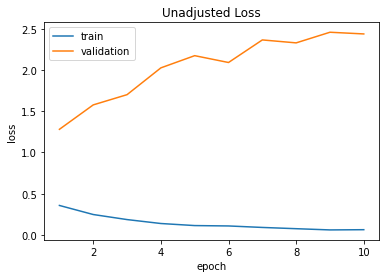

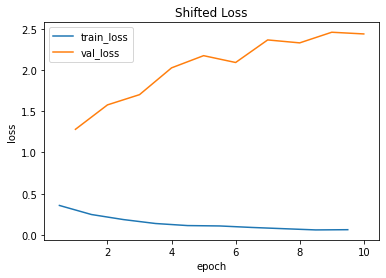

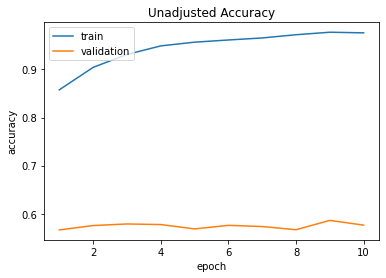

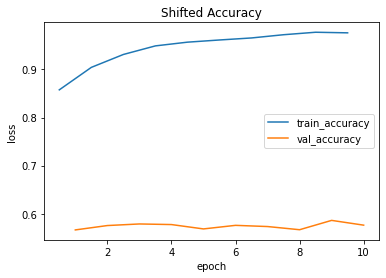

In [57]:
# summarize history for loss
ep_nbr = np.arange(1, len(history.history['accuracy']) + 1)
plt.plot(ep_nbr, history.history['loss'])
plt.plot(ep_nbr, history.history['val_loss'])
plt.title('Unadjusted Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Training loss is continually reported over the course of an entire epoch.
# Validation metrics are computed over the validation set only once the current training epoch is completed.
# This implies, that on average, training losses are measured half an epoch earlier.

# plot the *shifted* training and validation loss
plt.plot(ep_nbr - 0.5, history.history['loss'], label="train_loss")
plt.plot(ep_nbr, history.history['val_loss'], label="val_loss")
plt.title("Shifted Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(ep_nbr, history.history['accuracy'])
plt.plot(ep_nbr, history.history['val_accuracy'])
plt.title('Unadjusted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot the *shifted* training and validation accuracy
plt.plot(ep_nbr - 0.5, history.history['accuracy'], label="train_accuracy")
plt.plot(ep_nbr, history.history['val_accuracy'], label="val_accuracy")
plt.title("Shifted Accuracy")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [58]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [59]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [53]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission['prediction'] = submission['prediction'].astype(np.int32).replace([0,2], [2,0])
submission.to_csv('./Data/submission.csv', index=False)

In [54]:
temp = submission.groupby('prediction').count()['id'].reset_index().sort_values(by='id',ascending=False)
temp.style.background_gradient(cmap='Purples')

,prediction,id
2,2,1859
1,1,1812
0,0,1524


In [55]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2
